# Imports and Setup

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import seaborn as sns

import astropy
import astropy.units as u
import astropy.constants as const
from astropy.table import Table as t
from astropy.table import vstack, join
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

from astropy.wcs import WCS
from astropy.io import fits
from astropy.nddata import Cutout2D
from matplotlib.patches import Ellipse
from PIL import Image
from astropy.table import join, join_skycoord

In [3]:
c1, c2, c3, c4 = '#4e79a7', '#e15759', '#59a14f', '#b07aa1'
palette = sns.color_palette([c1, c2, c3, c4])

paper = lambda: sns.set(context='paper', font_scale=1.0, style='ticks', palette = palette,#'Set2',
                         rc={'figure.figsize':(4,3), 'figure.dpi':200, 'figure.facecolor':'w', 'figure.subplot.wspace':0.03,
                             'grid.alpha':0.15, 'axes.axisbelow':True, 
                             'xtick.bottom':True, 'ytick.left':True, 'xtick.direction':'in', 'ytick.direction':'in',
                             'legend.framealpha':0, 'legend.fontsize':'small', 'legend.handletextpad':0.1, 'legend.borderpad':0.2,
                             'errorbar.capsize':1, 
                             'image.cmap':'viridis',
                            })

paper()

In [79]:
np.random.seed(13)

# Downloading Data from MAST

In [ ]:
# from astroquery.mast import Observations
# all_obs = Observations.query_criteria(provenance_name="jades") # "ceers"
# data_products = Observations.get_product_list(all_obs)
# data_products.sort('size', reverse=True)
# Observations.download_products(data_products[[:8]])

# Data Pathing and Functions

In [23]:
# adjust data path as needed
data_path = '/media/team_workspaces/Galaxy-Zoo/Data/JADES-data-hayley/'

img_files = {'F090W':data_path+'images-by-band/hlsp_jades_jwst_nircam_goods-s-deep_f090w_v1.0_drz.fits',
             'F115W':data_path+'images-by-band/hlsp_jades_jwst_nircam_goods-s-deep_f115w_v1.0_drz.fits',
             'F150W':data_path+'images-by-band/hlsp_jades_jwst_nircam_goods-s-deep_f150w_v1.0_drz.fits',
             'F200W':data_path+'images-by-band/hlsp_jades_jwst_nircam_goods-s-deep_f200w_v1.0_drz.fits',
             'F277W':data_path+'images-by-band/hlsp_jades_jwst_nircam_goods-s-deep_f277w_v1.0_drz.fits',
             'F335M':data_path+'images-by-band/hlsp_jades_jwst_nircam_goods-s-deep_f335m_v1.0_drz.fits',
             'F444W':data_path+'images-by-band/hlsp_jades_jwst_nircam_goods-s-deep_f444w_v1.0_drz.fits',}

In [24]:
with fits.open(img_files['F090W']) as hdul:
    wcs = WCS(hdul[1].header)

In [25]:
jades = t.read(data_path+'hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits', hdu=3)
jades['sc'] = SkyCoord(jades['RA'], jades['DEC'], unit='deg')
jades.add_index('ID')

In [26]:
photometry = t.read(data_path+'hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits', hdu=7)
photometry.convert_bytestring_to_unicode()
photometry.add_index('ID')

bands = ['F090W','F115W','F150W','F200W', 'F277W', 'F335M', 'F356W', 'F444W']
for band in bands:
    jades[band] = photometry.loc[jades['ID']][band+'_KRON']
    jades[band+'_e'] = photometry.loc[jades['ID']][band+'_KRON_ei']

In [27]:
from astropy.visualization import make_lupton_rgb

img_r = fits.open(img_files['F444W'])[1].data
img_g = fits.open(img_files['F200W'])[1].data
img_b = fits.open(img_files['F090W'])[1].data


def make_rgb_image(jades_id, draw_ellipse=True):

    row = jades.loc[jades_id]

    img_r_crop = img_r[row['BBOX_YMIN']:row['BBOX_YMAX'],row['BBOX_XMIN']:row['BBOX_XMAX']]
    img_g_crop = img_g[row['BBOX_YMIN']:row['BBOX_YMAX'],row['BBOX_XMIN']:row['BBOX_XMAX']]
    img_b_crop = img_b[row['BBOX_YMIN']:row['BBOX_YMAX'],row['BBOX_XMIN']:row['BBOX_XMAX']]


    fig, ax = plt.subplots(figsize=(4,4))
    rgb = make_lupton_rgb(img_r_crop*1.1, img_g_crop*0.75, img_b_crop*0.4,  minimum=0, Q=2, stretch=0.1)
    ax.imshow(rgb, origin = 'lower')

    if draw_ellipse:
        A_pix = ((row['A']*u.arcsec)/wcs.proj_plane_pixel_scales()[0]).decompose().value
        B_pix = ((row['B']*u.arcsec)/wcs.proj_plane_pixel_scales()[0]).decompose().value

        ellipse = Ellipse(xy=(row['XC']-row['BBOX_XMIN'], row['YC']-row['BBOX_YMIN']),
                          width=A_pix, height=B_pix, angle=row['PA'],
                          facecolor='none', edgecolor='w', linewidth=0.5, linestyle='dashed', alpha=0.35)

        ax.add_patch(ellipse)

    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [28]:
def make_3_band_image(jades_id, draw_ellipse=True):
        
    bbox_dx = jades.loc[jades_id]['BBOX_XMAX']-jades.loc[jades_id]['BBOX_XMIN']
    bbox_dy = jades.loc[jades_id]['BBOX_YMAX']-jades.loc[jades_id]['BBOX_YMIN']

    img_color_data = {'F444W': np.zeros((bbox_dx, bbox_dy)),
                      'F200W': np.zeros((bbox_dx, bbox_dy)),
                      'F090W': np.zeros((bbox_dx, bbox_dy))}

    for band in ['F444W','F200W','F090W']:
        with fits.open(img_files[band]) as hdul:
            img_color_data[band] = hdul[1].data[jades.loc[jades_id]['BBOX_YMIN']:jades.loc[jades_id]['BBOX_YMAX'],jades.loc[jades_id]['BBOX_XMIN']:jades.loc[jades_id]['BBOX_XMAX']]

    fig, ax = plt.subplots(ncols=3, figsize=((bbox_dy/bbox_dx)*2+1,2), sharex=True, sharey=True)
    ax[0].imshow(img_color_data['F444W'], origin='lower', cmap='mako')
    ax[1].imshow(img_color_data['F200W'], origin='lower', cmap='mako')
    ax[2].imshow(img_color_data['F090W'], origin='lower', cmap='mako')
    
    ax[0].text(0, 1, 'F444W', color='white', fontsize='x-small', transform=ax[0].transAxes, va='top', ha='left')
    ax[1].text(0, 1, 'F200W', color='white', fontsize='x-small', transform=ax[1].transAxes, va='top', ha='left')
    ax[2].text(0, 1, 'F090W', color='white', fontsize='x-small', transform=ax[2].transAxes, va='top', ha='left')

    if draw_ellipse:
        A_pix = ((jades.loc[jades_id]['A']*u.arcsec)/wcs.proj_plane_pixel_scales()[0]).decompose().value
        B_pix = ((jades.loc[jades_id]['B']*u.arcsec)/wcs.proj_plane_pixel_scales()[0]).decompose().value

        for ai in range(3):
            ellipse = Ellipse(xy=(jades.loc[jades_id]['XC']-jades.loc[jades_id]['BBOX_XMIN'], jades.loc[jades_id]['YC']-jades.loc[jades_id]['BBOX_YMIN']),
                              width=A_pix, height=B_pix, angle=jades.loc[jades_id]['PA'],
                              facecolor='none', edgecolor='w', linewidth=0.5, linestyle='dashed', alpha=0.5)

            ax[ai].add_patch(ellipse)

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

In [29]:
def make_6_band_image(jades_id, draw_ellipse=True):

    bands = ['F090W','F115W','F150W','F200W','F335M','F444W']

    bbox_dx = jades.loc[jades_id]['BBOX_XMAX']-jades.loc[jades_id]['BBOX_XMIN']
    bbox_dy = jades.loc[jades_id]['BBOX_YMAX']-jades.loc[jades_id]['BBOX_YMIN']

    A_pix = ((jades.loc[jades_id]['A']*u.arcsec)/wcs.proj_plane_pixel_scales()[0]).decompose().value
    B_pix = ((jades.loc[jades_id]['B']*u.arcsec)/wcs.proj_plane_pixel_scales()[0]).decompose().value

    img_color_data = {}
    for band in bands:
        with fits.open(img_files[band]) as hdul:
            img_color_data[band] = hdul[1].data[jades.loc[jades_id]['BBOX_YMIN']:jades.loc[jades_id]['BBOX_YMAX'],jades.loc[jades_id]['BBOX_XMIN']:jades.loc[jades_id]['BBOX_XMAX']]

    fig, ax = plt.subplots(ncols=len(bands), figsize=(len(bands)*2,2.5), sharex=True, sharey=True) #(bbox_dy/bbox_dx)*3+1,3)

    for bi in range(len(bands)):
        ax[bi].imshow(img_color_data[bands[bi]], origin='lower', cmap='mako')
        ax[bi].text(1, 1, bands[bi], color='white', fontsize='x-small', transform=ax[bi].transAxes, va='top', ha='right')

        ellipse = Ellipse(xy=(jades.loc[jades_id]['XC']-jades.loc[jades_id]['BBOX_XMIN'], jades.loc[jades_id]['YC']-jades.loc[jades_id]['BBOX_YMIN']),
                          width=A_pix, height=B_pix, angle=jades.loc[jades_id]['PA'],
                          facecolor='none', edgecolor='w', linewidth=0.5, linestyle='dashed', alpha=0.5)
        ax[bi].add_patch(ellipse) 


    ax[0].set_xticks([])
    ax[0].set_yticks([])

    plt.tight_layout()
    plt.show()

# Example Images

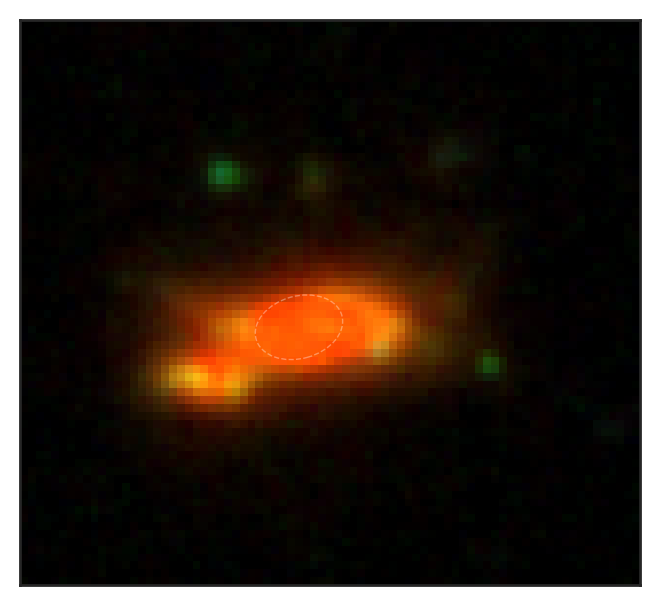

In [30]:
make_rgb_image(204182)

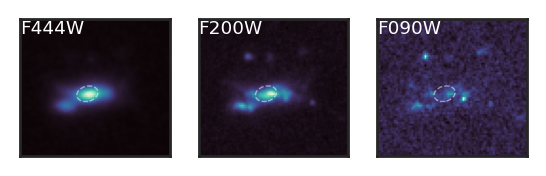

In [31]:
make_3_band_image(204182)

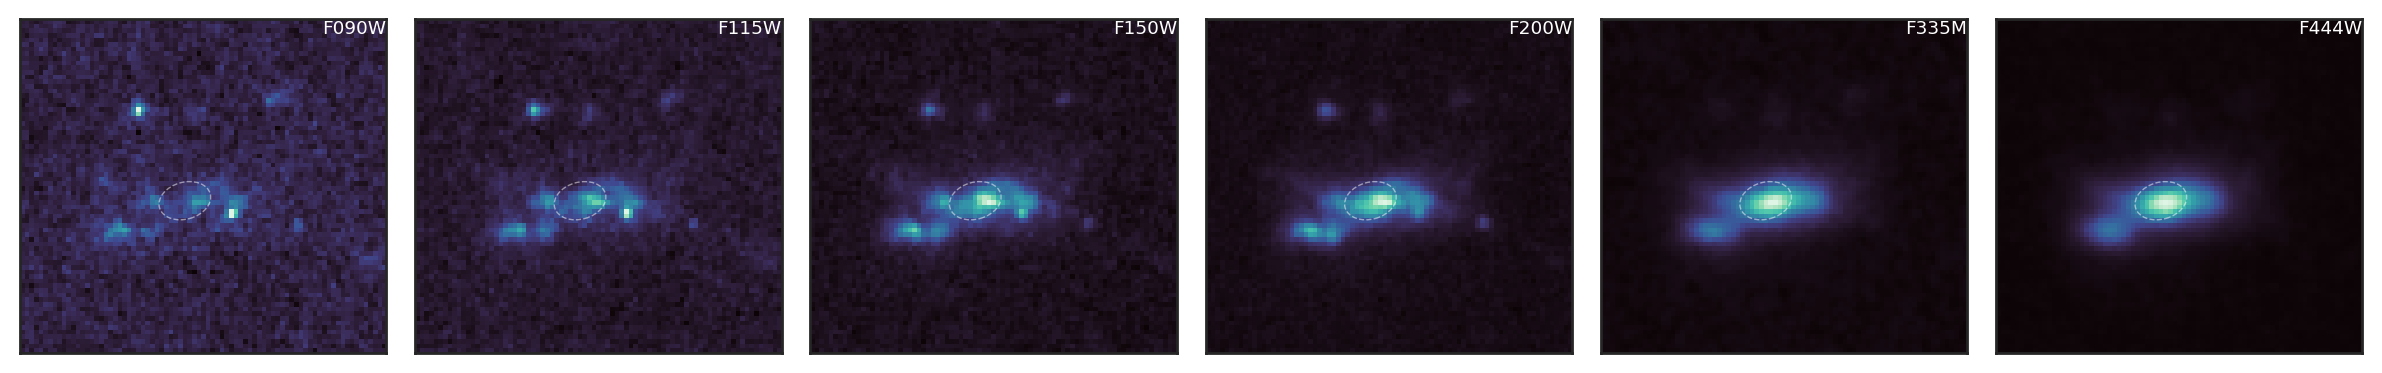

In [32]:
make_6_band_image(204182)

# Galaxies Worth Plotting

In [33]:
jades['BBOX_XSIZE'] = jades['BBOX_XMAX'] - jades['BBOX_XMIN']
jades['BBOX_YSIZE'] = jades['BBOX_YMAX'] - jades['BBOX_YMIN']
jades['BBOX_SIZE'] = jades['BBOX_XSIZE']*jades['BBOX_YSIZE']

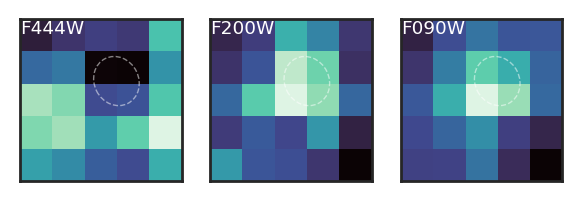

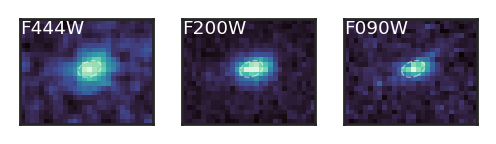

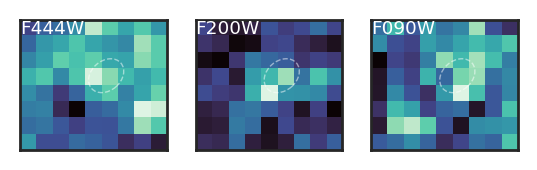

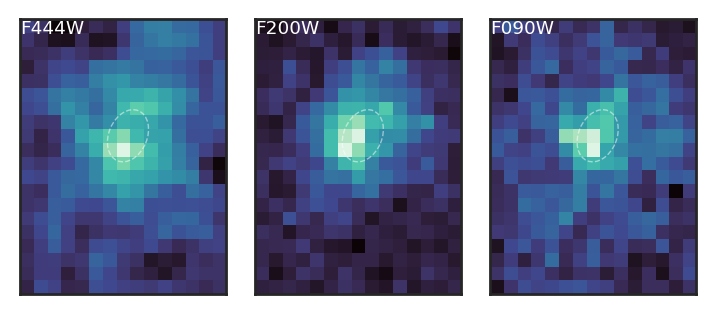

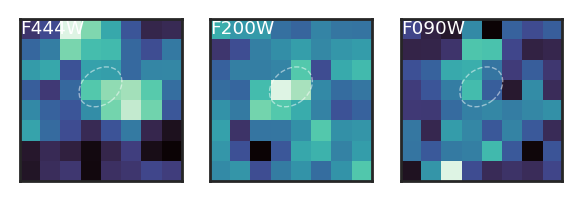

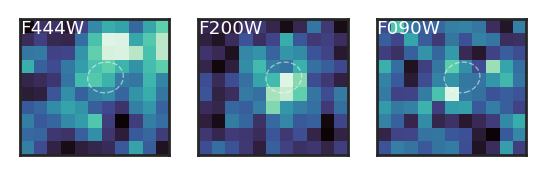

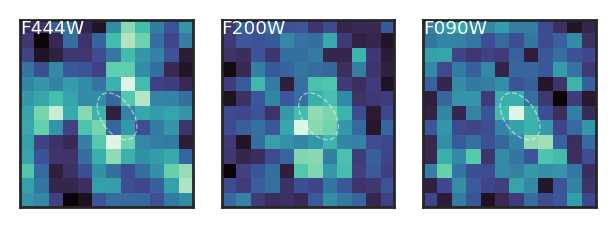

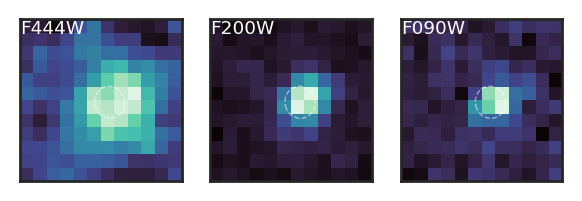

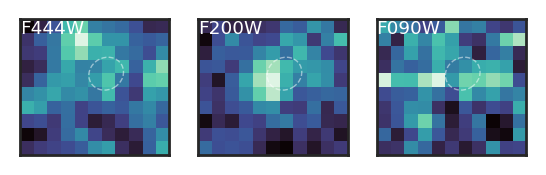

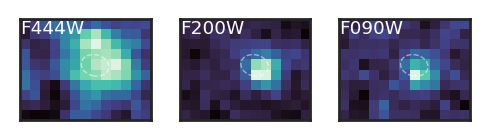

In [34]:
count = 0
for i in range(len(jades)):
    if jades['BBOX_SIZE'][i] >= 250 or jades['BBOX_SIZE'][i] <= 100000:
        make_3_band_image(jades['ID'][i])
        count = count+1
        
    if count == 10:
        break
        

# More Plots

In [97]:
def make_square_images(jades_id, size=50):
    bands = ['F090W', 'F150W', 'F277W', 'F444W']

    x_min = int(jades.loc[jades_id]['XC'] - size/2)
    x_max = int(jades.loc[jades_id]['XC'] + size/2)

    y_min = int(jades.loc[jades_id]['YC'] - size/2)
    y_max = int(jades.loc[jades_id]['YC'] + size/2)

    img_color_data = {}
    for band in bands:
        with fits.open(img_files[band]) as hdul:
            img_color_data[band] = hdul[1].data[y_min:y_max,x_min:x_max]
            
        

    fig, ax = plt.subplots(ncols=4, figsize=(6,2.5), sharex=True, sharey=True)
    ax[0].imshow(img_color_data['F090W'], origin='lower', cmap='mako')
    ax[1].imshow(img_color_data['F150W'], origin='lower', cmap='mako')
    ax[2].imshow(img_color_data['F277W'], origin='lower', cmap='mako')
    ax[3].imshow(img_color_data['F444W'], origin='lower', cmap='mako')

    scale_npix = ((0.5*u.arcsec)/wcs.proj_plane_pixel_scales()[0]).decompose()
    scale_height = 0.1*img_color_data['F090W'].shape[0]
    scale_start = 0.1*img_color_data['F090W'].shape[1]
    ax[0].plot([scale_start, scale_start+scale_npix], [scale_height, scale_height], color='white', linewidth=0.5)
    ax[0].plot([scale_start, scale_start], [scale_height-scale_npix/10, scale_height+scale_npix/10], color='white', linewidth=0.5)
    ax[0].plot([scale_start+scale_npix, scale_start+scale_npix], [scale_height-scale_npix/10, scale_height+scale_npix/10], color='white', linewidth=0.5)
    ax[0].text(scale_start+scale_npix/2, scale_height, '0.5"', color='white', fontsize=5, va='bottom', ha='center')


    ax[0].text(1, 1, 'F090W', color='white', fontsize='x-small', transform=ax[0].transAxes, va='top', ha='right')
    ax[1].text(1, 1, 'F150W', color='white', fontsize='x-small', transform=ax[1].transAxes, va='top', ha='right')
    ax[2].text(1, 1, 'F277W', color='white', fontsize='x-small', transform=ax[2].transAxes, va='top', ha='right')
    ax[3].text(1, 1, 'F444W', color='white', fontsize='x-small', transform=ax[3].transAxes, va='top', ha='right')


    A_pix = ((jades.loc[jades_id]['A']*u.arcsec)/wcs.proj_plane_pixel_scales()[0]).decompose().value
    B_pix = ((jades.loc[jades_id]['B']*u.arcsec)/wcs.proj_plane_pixel_scales()[0]).decompose().value

    for ai in range(4):
        ellipse = Ellipse(xy=(jades.loc[jades_id]['XC']-x_min, jades.loc[jades_id]['YC']-y_min),
                          width=A_pix, height=B_pix, angle=jades.loc[jades_id]['PA'],
                          facecolor='none', edgecolor='w', linewidth=0.5, linestyle='dashed', alpha=0.75)

        ax[ai].add_patch(ellipse)

    ax[0].set_xticks([])
    ax[0].set_yticks([])


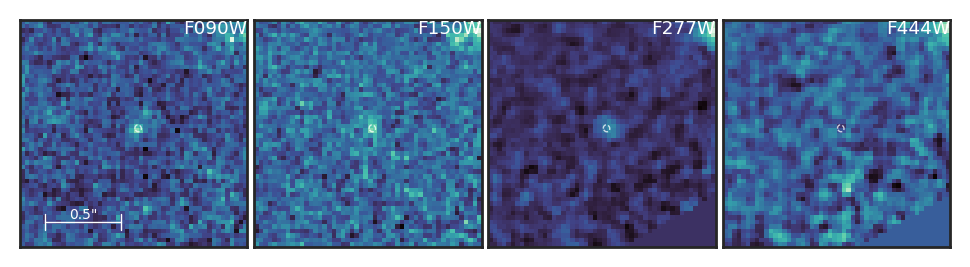

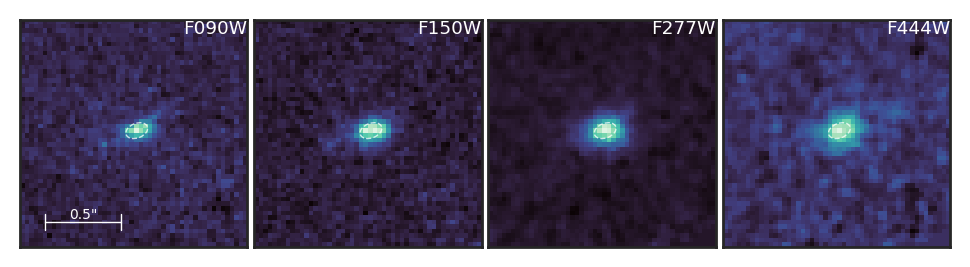

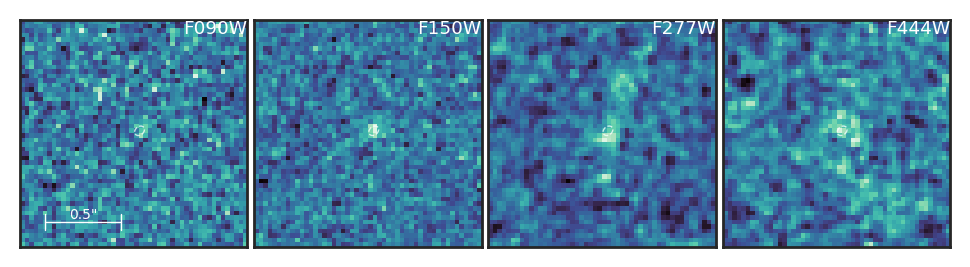

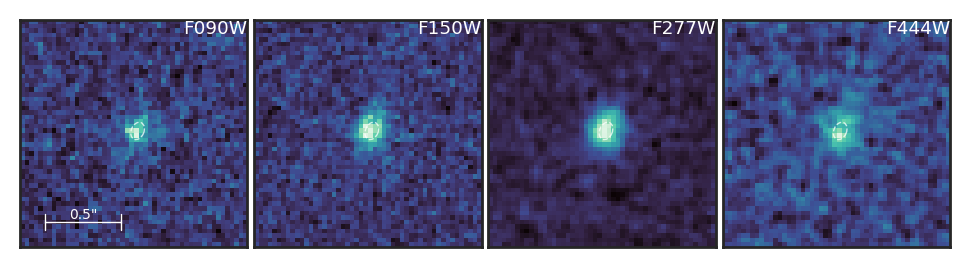

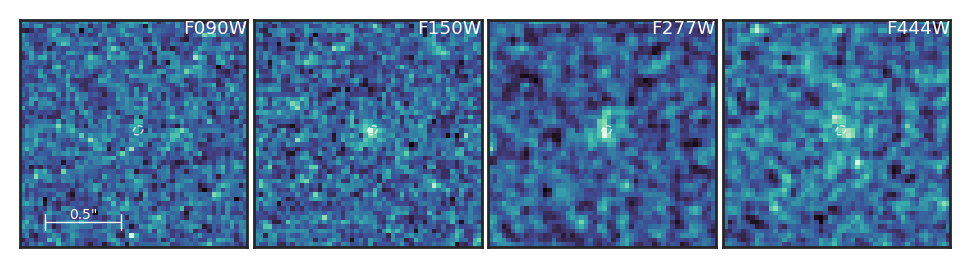

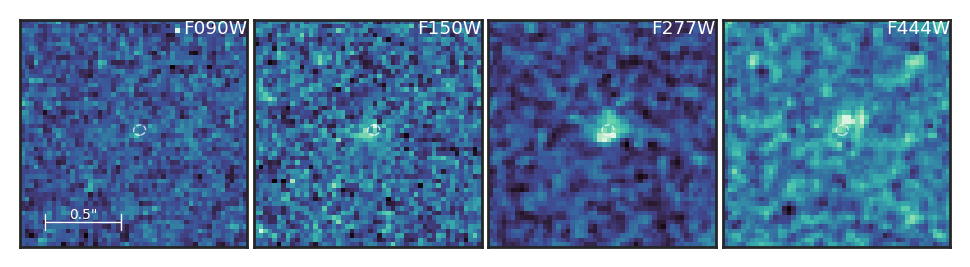

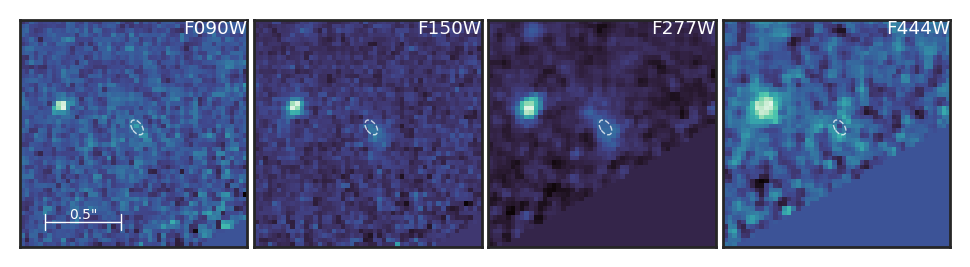

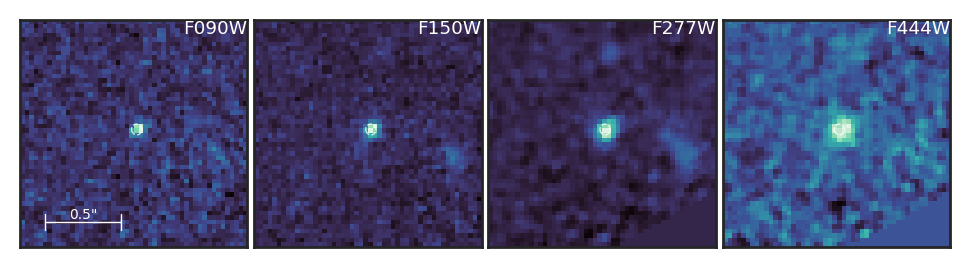

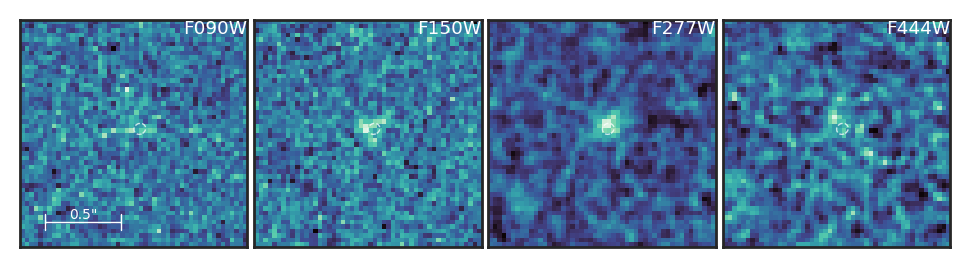

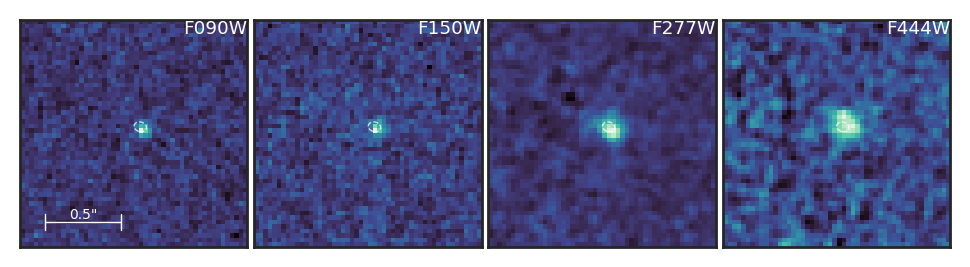

In [98]:
count = 0
for i in range(len(jades)):
    if jades['BBOX_SIZE'][i] >= 250 or jades['BBOX_SIZE'][i] <= 100000:
        make_square_images(jades['ID'][i])
        count = count+1
        
    if count == 10:
        break
        

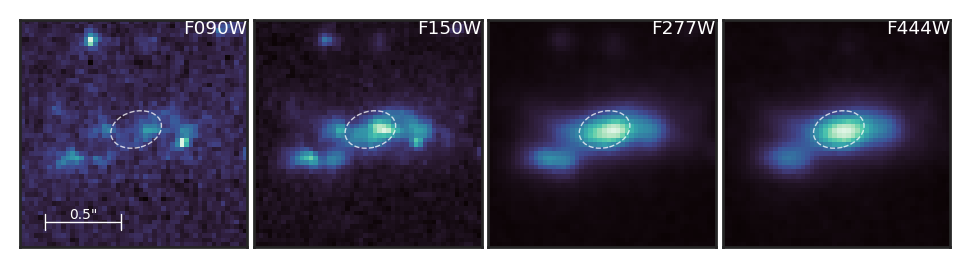

In [143]:
make_square_images(204182)

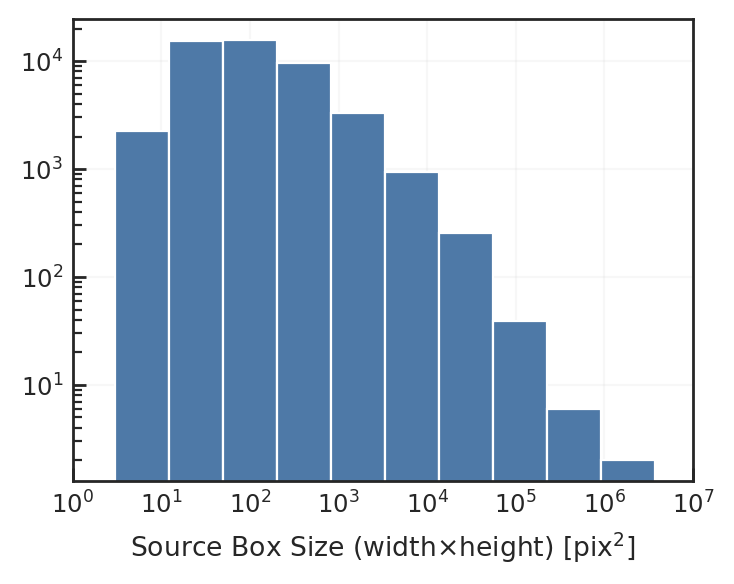

In [61]:
plt.hist(np.log10(jades['BBOX_SIZE']), log=True)
plt.xlabel(r'Source Box Size (width$\times$height) [pix$^2$]')
xticks = np.arange(8)
plt.xticks(xticks, labels=['10$^{'+str(int(xtick))+'}$' for xtick in xticks])
plt.grid()

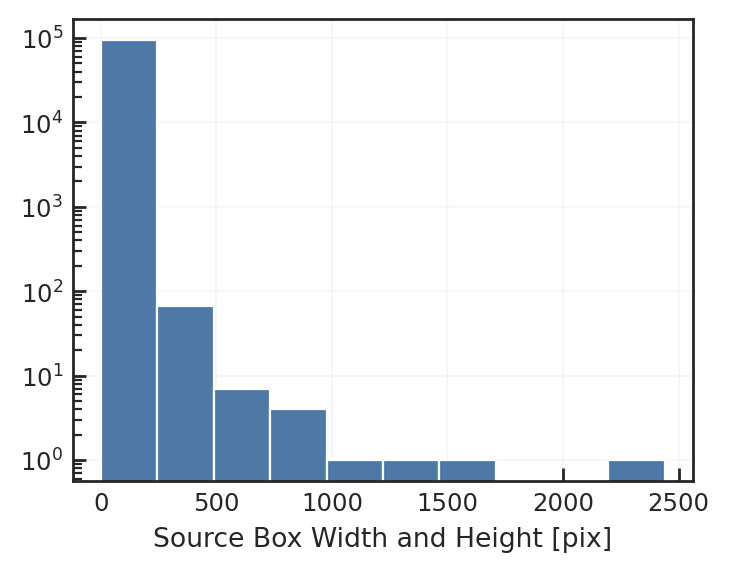

In [62]:
plt.hist(np.concatenate([jades['BBOX_XSIZE'],jades['BBOX_YSIZE']]), log=True)
plt.xlabel('Source Box Width and Height [pix]')
plt.grid()

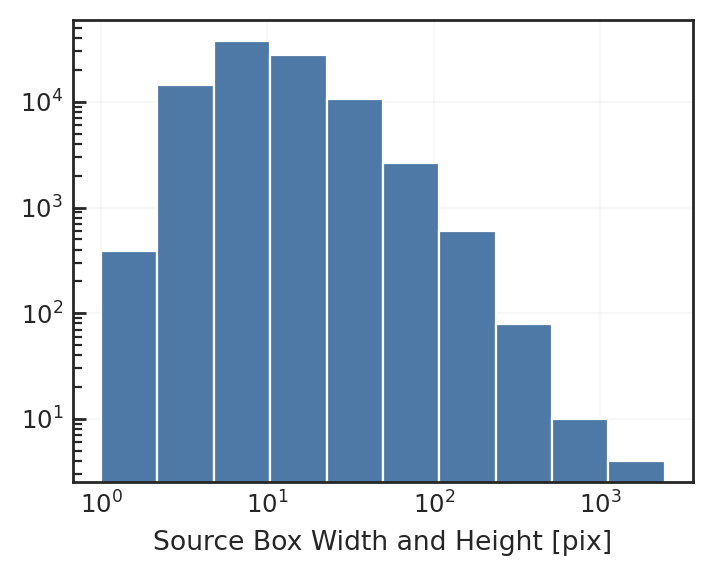

In [63]:
plt.hist(np.log10(np.concatenate([jades['BBOX_XSIZE'],jades['BBOX_YSIZE']])), log=True)
plt.xlabel('Source Box Width and Height [pix]')

xticks = np.arange(4)
plt.xticks(xticks, labels=['10$^{'+str(int(xtick))+'}$' for xtick in xticks])
plt.grid()

/tmp/ipykernel_740/3487455997.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(jades['BBOX_SIZE']), np.log10(jades[band]), s=1, alpha=0.25)
/tmp/ipykernel_740/3487455997.py:5: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(jades['BBOX_SIZE']), np.log10(jades[band]), s=1, alpha=0.25)
/tmp/ipykernel_740/3487455997.py:6: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(jades[rands]['BBOX_SIZE']), np.log10(jades[rands][band]), s=1)


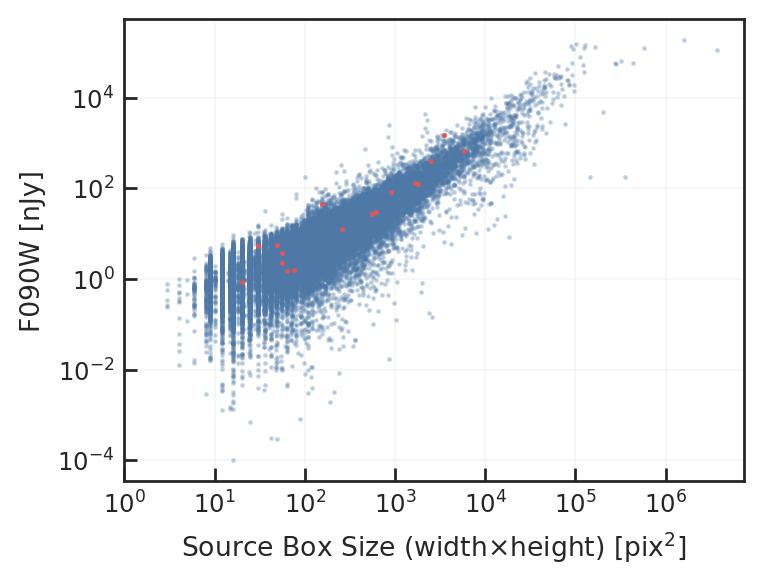

/tmp/ipykernel_740/3487455997.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(jades['BBOX_SIZE']), np.log10(jades[band]), s=1, alpha=0.25)
/tmp/ipykernel_740/3487455997.py:5: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(jades['BBOX_SIZE']), np.log10(jades[band]), s=1, alpha=0.25)


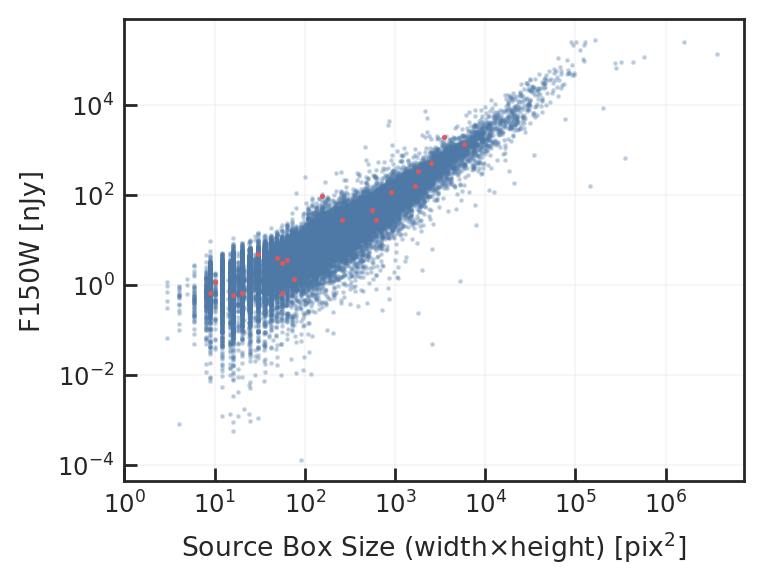

/tmp/ipykernel_740/3487455997.py:5: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(jades['BBOX_SIZE']), np.log10(jades[band]), s=1, alpha=0.25)


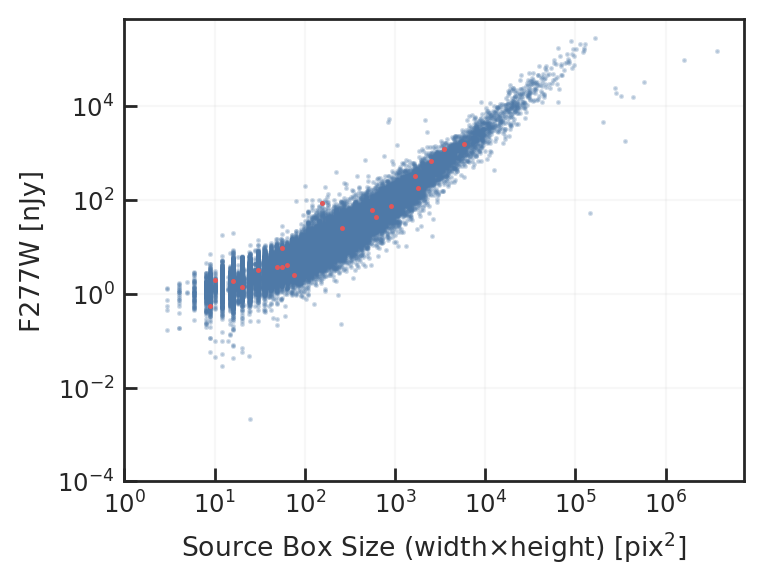

/tmp/ipykernel_740/3487455997.py:5: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(jades['BBOX_SIZE']), np.log10(jades[band]), s=1, alpha=0.25)


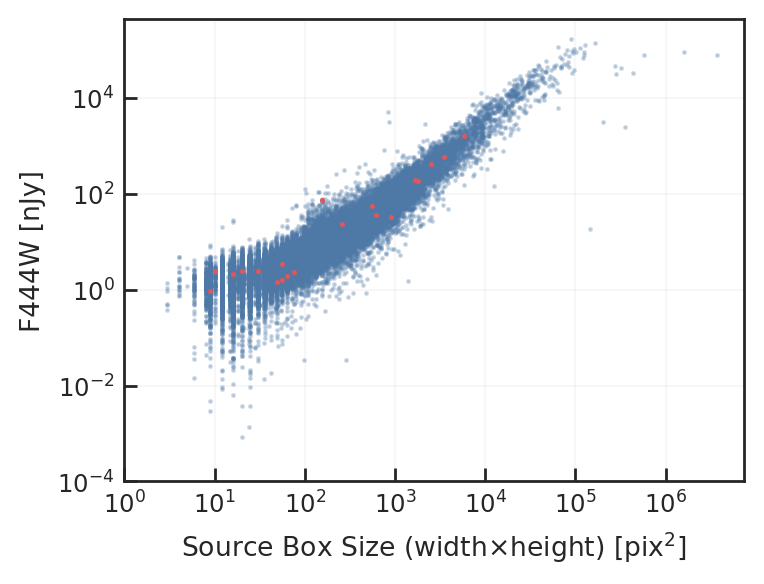

In [83]:
rands = np.random.choice(len(jades), size=20, replace=False)

for band in ['F090W', 'F150W', 'F277W', 'F444W']:
    plt.figure()
    plt.scatter(np.log10(jades['BBOX_SIZE']), np.log10(jades[band]), s=1, alpha=0.25)
    plt.scatter(np.log10(jades[rands]['BBOX_SIZE']), np.log10(jades[rands][band]), s=1)
    plt.xlabel(r'Source Box Size (width$\times$height) [pix$^2$]')
    plt.ylabel(band+' [nJy]')
    plt.xticks(np.arange(7), labels=['10$^{'+str(int(xtick))+'}$' for xtick in np.arange(7)])
    plt.yticks(np.arange(-4,5,2), labels=['10$^{'+str(int(xtick))+'}$' for xtick in np.arange(-4,5,2)])
    plt.grid()
    plt.show()

ID: 114981
box size: 256
F150W: 27.425457 

ID: 108963
box size: 616
F150W: 28.067957 

ID: 88328
box size: 551
F150W: 46.475452 

ID: 266661
box size: 154
F150W: 95.455894 

ID: 201979
box size: 912
F150W: 116.94945 

ID: 218007
box size: 1672
F150W: 157.9732 

ID: 197675
box size: 1804
F150W: 346.82162 

ID: 189917
box size: 2520
F150W: 516.3178 

ID: 208105
box size: 5775
F150W: 1396.6207 

ID: 201954
box size: 3480
F150W: 1982.1919 



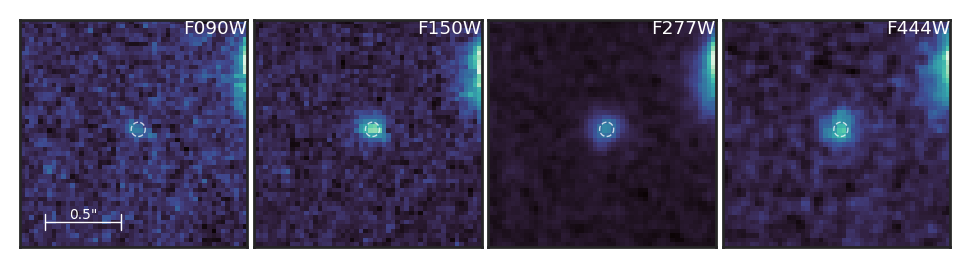

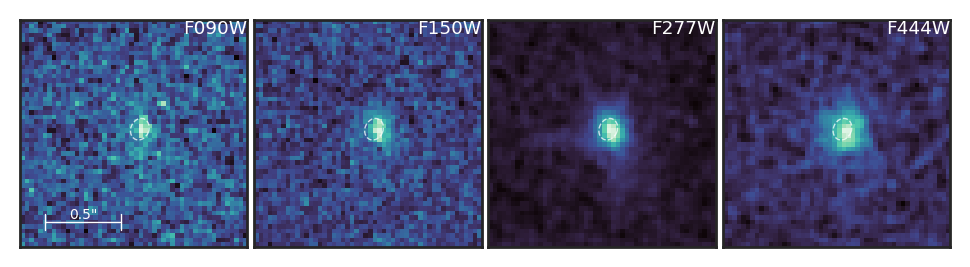

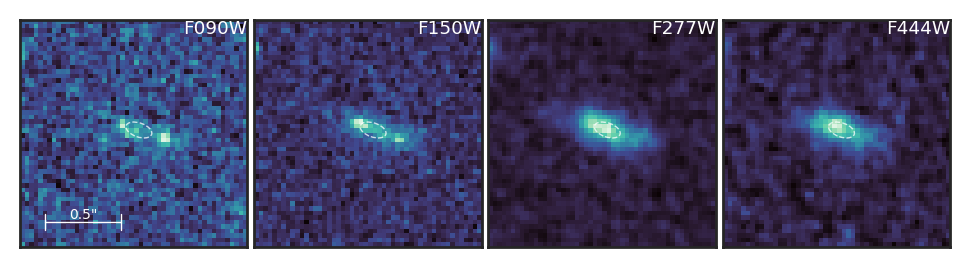

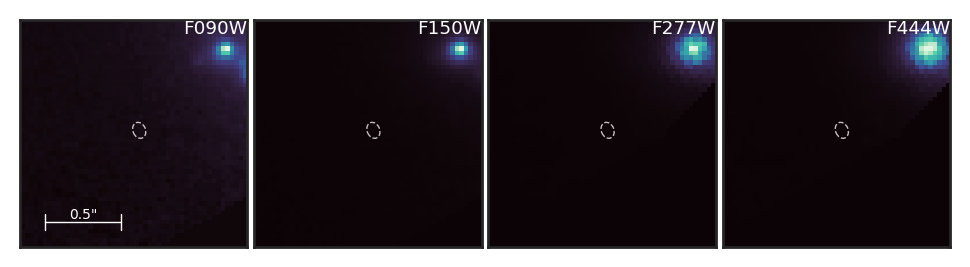

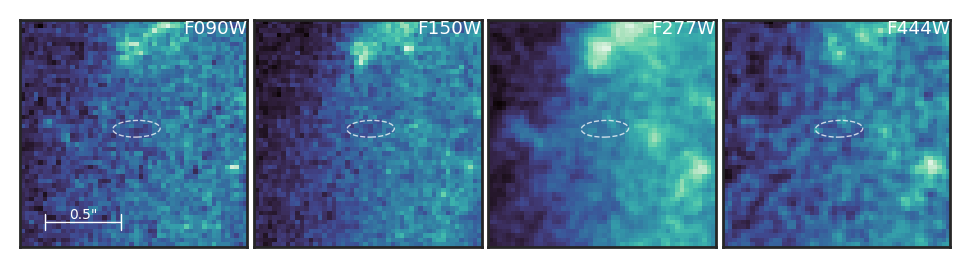

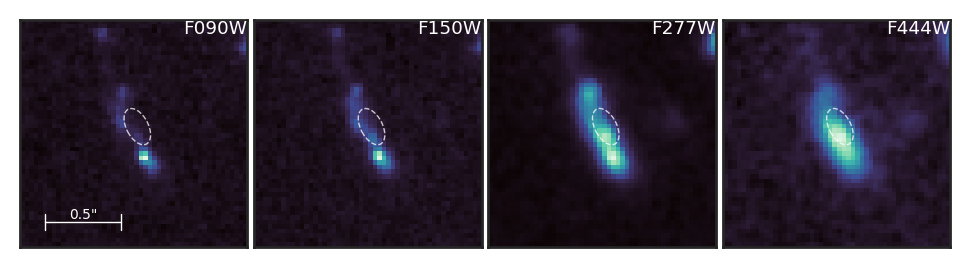

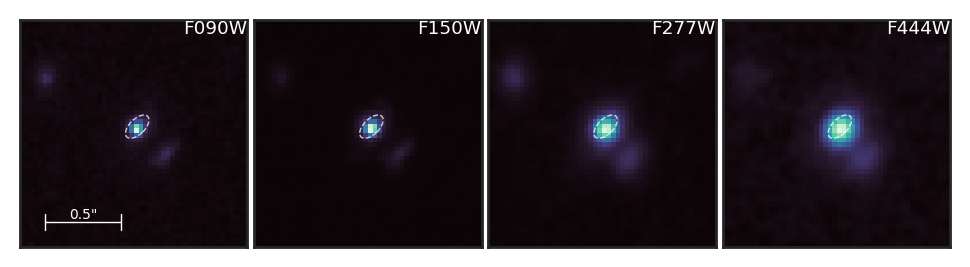

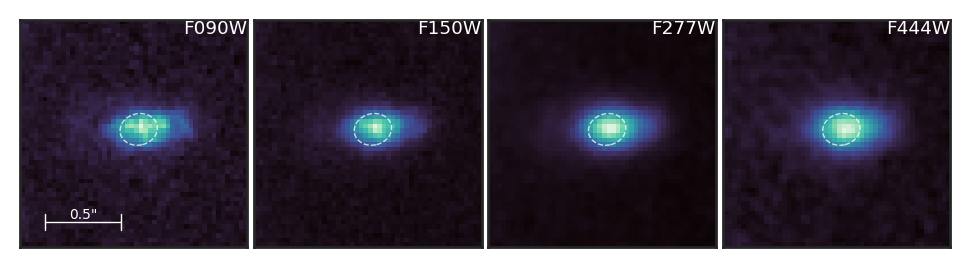

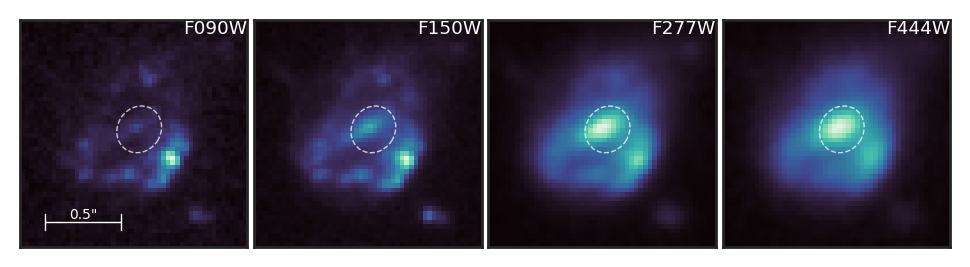

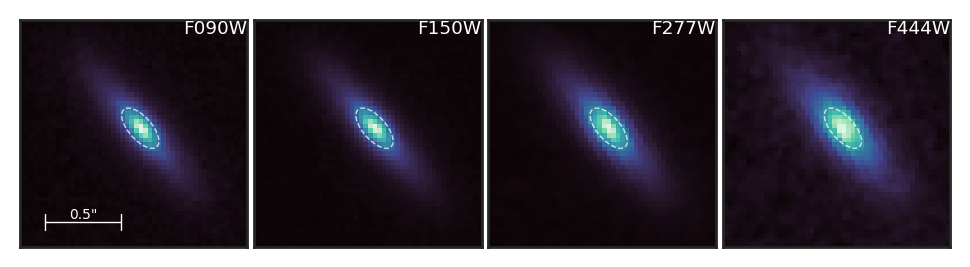

In [103]:
temp_jades = jades[rands]
temp_jades.sort('F150W')

for jades_id in temp_jades['ID'][10:]:
    print('ID:',jades_id)
    print('box size:', jades.loc[jades_id]['BBOX_SIZE'])
    print('F150W:', jades.loc[jades_id]['F150W'],'\n')
    make_square_images(jades.loc[jades_id]['ID'])

In [125]:
jades['sum_4bands'] = jades['F090W']+jades['F150W']+jades['F277W']+jades['F444W']

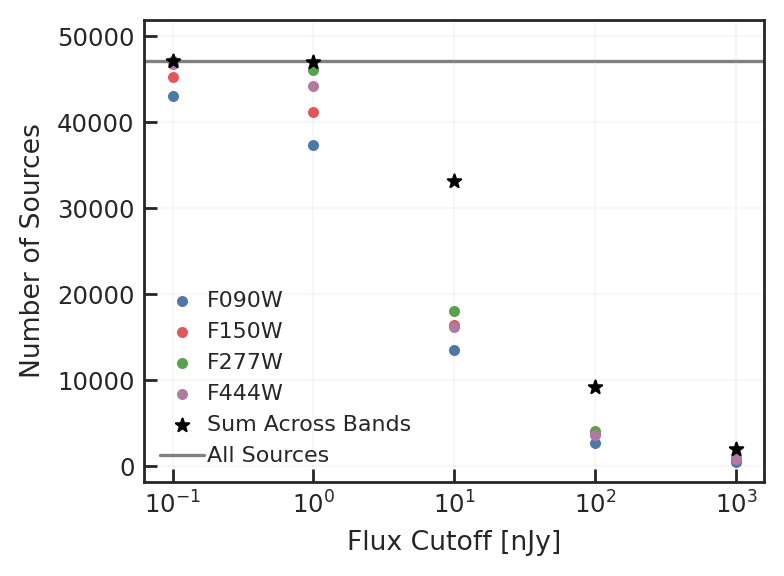

In [132]:
lims = [-1,0,1,2,3]

num_per_lim = {'F090W': [len(jades[jades['F090W']>=10**lim]) for lim in lims],
               'F150W': [len(jades[jades['F150W']>=10**lim]) for lim in lims],
               'F277W': [len(jades[jades['F277W']>=10**lim]) for lim in lims],
               'F444W': [len(jades[jades['F444W']>=10**lim]) for lim in lims],
               'all': [len(jades[jades['sum_4bands']>=10**lim]) for lim in lims],}


for band in num_per_lim.keys():
    if band != 'all':
        plt.scatter(lims, num_per_lim[band], label=band, s=10)
    

plt.scatter(lims, num_per_lim['all'], label='Sum Across Bands', s=25, color='k', marker='*')

plt.axhline(len(jades), color='grey', label='All Sources', zorder=0)
plt.ylim(top=len(jades)*1.1)
plt.xticks(lims, labels=['10$^{'+str(lim)+'}$' for lim in lims])
plt.xlabel('Flux Cutoff [nJy]')
plt.ylabel('Number of Sources')
plt.legend()
plt.grid()

In [139]:
def flux_to_mag(flux, error=None):
    mag = -2.5*np.log10((flux*u.nJy)/((3631*u.Jy).to(u.nJy)))
    if error:
        mag_err = 0.434*error/flux
        return mag.value, mag_err
    return mag.value

In [137]:
jades

ID,RA,DEC,NPIX_DET,X,Y,XC,YC,BBOX_XMIN,BBOX_XMAX,BBOX_YMIN,BBOX_YMAX,R_KRON,R_KRON_S,PA,Q,A,B,FWHM,GINI,F090W_RHALF,F115W_RHALF,F150W_RHALF,F182M_RHALF,F200W_RHALF,F210M_RHALF,F277W_RHALF,F335M_RHALF,F356W_RHALF,F410M_RHALF,F430M_RHALF,F444W_RHALF,F460M_RHALF,F480M_RHALF,F435W_RHALF,F606W_RHALF,F775W_RHALF,F814W_RHALF,F850LP_RHALF,F105W_RHALF,F125W_RHALF,F140W_RHALF,F160W_RHALF,sc,F090W,F090W_e,F115W,F115W_e,F150W,F150W_e,F200W,F200W_e,F277W,F277W_e,F335M,F335M_e,F356W,F356W_e,F444W,F444W_e,BBOX_XSIZE,BBOX_YSIZE,BBOX_SIZE,sum_4bands
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,
uint32,float64,float64,float32,float64,float64,float64,float64,uint32,uint32,uint32,uint32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,SkyCoord,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint32,uint32,uint32,float32
75224,53.17110096372104,-27.84686782268497,32.0,6795.673988923981,480.7278407860255,6795.483807988327,480.59251975375315,6793,6798,478,483,0.12732278,0.06111494,-63.513206,0.88417786,0.046603132,0.04120546,0.10358187,0.19103307,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,0.06608012,"53.17110096372104,-27.84686782268497",6.3867645,1.265915,4.5631223,0.81971,4.1538024,0.95568556,4.1215973,0.78845894,4.8681583,0.39591455,3.6564443,0.56117445,4.512859,0.40408537,0.9988211,0.6912671,5,5,25,16.407547
75383,53.17083837041982,-27.846682220101652,412.0,6823.532351044762,503.01501857192125,6823.174393600043,503.0843785764939,6809,6837,492,514,0.38962814,0.18702152,21.132788,0.6431034,0.14925438,0.095986,0.29548153,0.5499338,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,0.13346335,"53.17083837041982,-27.846682220101652",74.35676,3.148772,61.530575,2.175741,61.02257,2.5772562,75.79048,2.1238353,75.56491,0.9168641,79.00455,1.2213573,74.835556,0.86225814,56.16877,1.3955637,28,22,616,267.113
75717,53.17109456647576,-27.846373113924294,66.0,6796.329526439621,540.1036074424682,6795.783248263596,540.0559109824954,6791,6800,536,544,0.16986464,0.08153503,41.027805,0.76302606,0.071330756,0.05442723,0.1494003,0.23417199,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,0.15643682,"53.17109456647576,-27.846373113924294",1.5733465,1.5158083,1.9112614,1.0334806,5.6380367,1.2289513,2.530542,0.9807678,5.0233293,0.3887959,6.540984,0.543921,4.456094,0.3962396,7.587172,0.6708142,9,8,72,19.821884
75839,53.17159248070309,-27.846229791523516,238.0,6743.482508766357,557.2844027137206,6743.360788019288,557.0204828178579,6736,6751,546,566,0.31032103,0.1489541,67.148254,0.7061922,0.11843764,0.08363973,0.24142982,0.4399455,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,0.12929542,"53.17159248070309,-27.846229791523516",35.007248,2.5857637,42.32043,1.7746048,42.874966,2.093257,41.836452,1.7060167,35.80373,0.63835955,29.641836,0.868485,30.63705,0.6222195,21.724396,1.0159053,15,20,300,135.41034
75908,53.170773681902695,-27.84618964609752,59.0,6830.374175459532,562.1369893019216,6830.484330097193,562.161052

In [140]:
flux_to_mag(jades[0]['F150W'], error=jades[0]['F150W_e'])

(29.85395104131519, 0.0998524946175335)